In [29]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import pandas as pd 
import os 
import random 
import pathlib 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
root_path = "data/"

In [4]:
os.listdir(root_path + "train/")

['Interior', 'Exterior']

In [5]:
from PIL import ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
num_interior_train = len(os.listdir(root_path + "train/Interior/"))
num_exterior_train = len(os.listdir(root_path + "train/Exterior/"))
total_train = num_interior_train + num_exterior_train
print("Total training images:", total_train)
print("Total interior training images:", num_interior_train)
print("Total exterior training images:", num_exterior_train)

Total training images: 1600
Total interior training images: 800
Total exterior training images: 800


In [7]:
#get class names
data_dir = pathlib.Path(root_path + "train/")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['Exterior', 'Interior'], dtype='<U8')

In [8]:
def random_img(dirpath, category):
    directory = dirpath + "/" + category 
    random_img = random.sample(os.listdir(directory), 1)
    img = mpimg.imread(directory + "/" +random_img[0])
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
    print(f"Image shape: {img.shape}")
    return img

Image shape: (480, 854, 3)


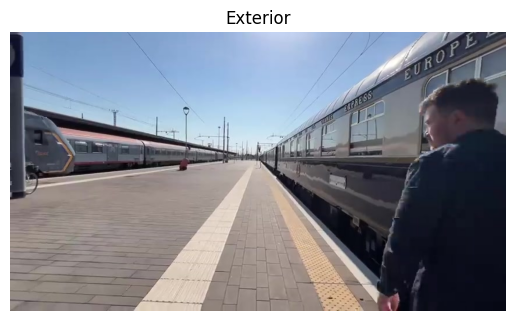

In [9]:
img = random_img(root_path + "train", class_names[0])

In [10]:
#data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_dir = root_path + "train/"
test_dir = root_path + "test/"
val_dir = root_path + "val/"

In [13]:
train_data = train_datagen.flow_from_directory(directory=train_dir ,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode='binary',)
test_data = test_datagen.flow_from_directory(directory=test_dir ,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode='binary',)
val_data = val_datagen.flow_from_directory(directory=val_dir ,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode='binary',)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [30]:
early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [31]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
baseline_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])
baseline_model.summary()

/home/andrealoy/Documents/repos/interior_exterior_classification/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        28,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,101 (121.49 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
baseline_model_loss = baseline_model.fit(train_data,epochs=20,steps_per_epoch=len(train_data),
                                         validation_data=val_data,
                                         validation_steps=len(val_data),
                                         callbacks=[early_stop])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.5025 - loss: 0.6934 - val_accuracy: 0.5100 - val_loss: 0.6774
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.5763 - loss: 0.6687 - val_accuracy: 0.6100 - val_loss: 0.6638
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.6369 - loss: 0.6288 - val_accuracy: 0.6950 - val_loss: 0.5715
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.7475 - loss: 0.4898 - val_accuracy: 0.7800 - val_loss: 0.4635
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.7731 - loss: 0.4850 - val_accuracy: 0.8000 - val_loss: 0.4414
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.8056 - loss: 0.4332 - val_accuracy: 0.8000 - val_loss: 0.4436
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.7875 - loss: 0.4463 - val_accuracy: 0.8200 - val_loss: 0.4207
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.8056 - loss: 0.4189 - val_accuracy: 0

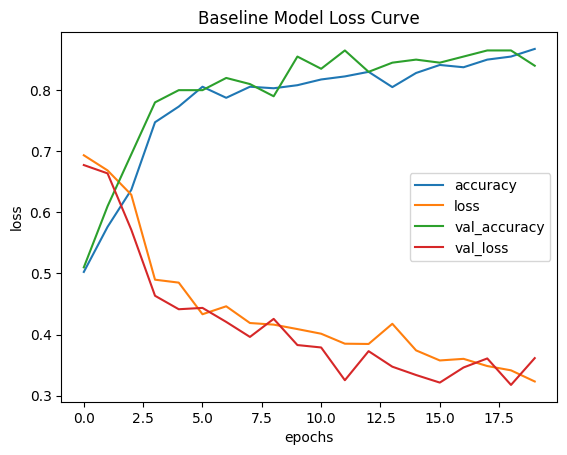

In [33]:
pd.DataFrame(baseline_model_loss.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("Baseline Model Loss Curve")
plt.show()

In [34]:
#Evaluate the model on the test data
baseline_model.evaluate(test_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8750 - loss: 0.3121


[0.3121426999568939, 0.875]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicted label: Interior, True label: Interior
Confidence: 97.92%


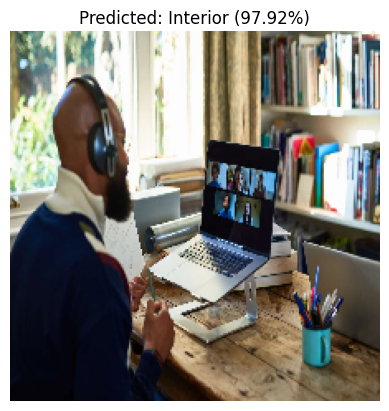

In [35]:
#test a random image outside of the dataset 
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path , true_label): 
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0) #create batch axis
    img_array = img_array/255.0 #rescale
    prediction = model.predict(img_array)
    if prediction < 0.5:
        pred_label = "Exterior"
    else:
        pred_label = "Interior"
    print(f"Predicted label: {pred_label}, True label: {true_label}")
    confidence = 1 - prediction if prediction < 0.5 else prediction
    print(f"Confidence: {confidence[0][0]*100:.2f}%")
    return img , pred_label, confidence 

test_image_path = "random_images/home_office.jpg"
img, pred_label, confidence = predict_image(baseline_model, test_image_path, "Interior")
plt.imshow(img)
plt.title(f"Predicted: {pred_label} ({confidence[0][0]*100:.2f}%)")
plt.axis("off")
plt.show()

In [36]:
#predict image from the web 
import requests
from io import BytesIO 

def pred_show_image_web(model,url, true_label):
    response = requests.get(url)
    img_data = BytesIO(response.content)
    img , pred_label, confidence = predict_image(model, img_data, true_label)
    img = image.load_img(img_data, target_size=(224,224))
    plt.imshow(img)
    plt.title(f"Predicted: {pred_label} ({confidence[0][0]*100:.2f}%)")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted label: Interior, True label: Interior
Confidence: 71.70%


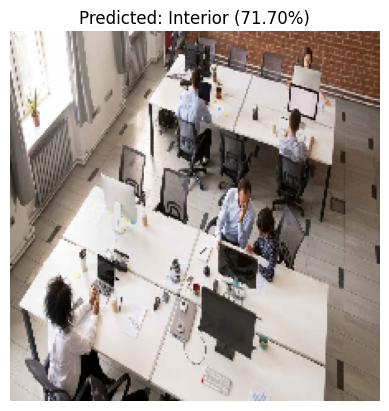

In [37]:
pred_show_image_web(baseline_model, url = "https://scolaconsult.fr/wp-content/uploads/2025/07/OPEN-SPACE.jpg", true_label="Interior")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted label: Exterior, True label: Exterior
Confidence: 99.99%


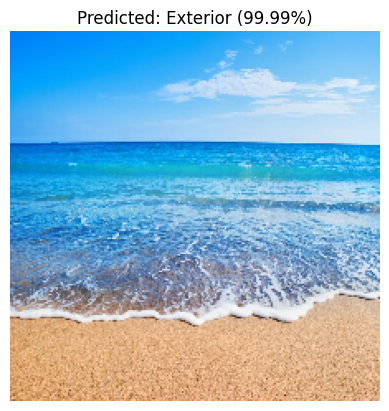

In [38]:

pred_show_image_web(baseline_model, url = "https://cdn.mos.cms.futurecdn.net/wtqqnkYDYi2ifsWZVW2MT4-1000-80.jpg", true_label="Exterior")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted label: Interior, True label: Exterior
Confidence: 72.04%


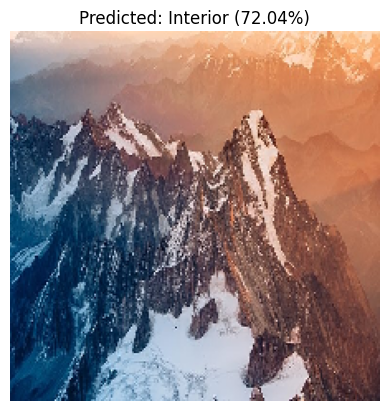

In [39]:
pred_show_image_web(baseline_model, url = "https://www.mountainwilderness.fr/media/images/videos/mobile/_768x375_crop_center-center_none/Mountain_Wild%C2%A9MathisDumas-768_2024-05-31-092042_udgi.jpg", true_label="Exterior")

In [40]:
from tensorflow.keras import layers, models 
from tensorflow.keras.applications import MobileNetV2


In [41]:
model_1 = MobileNetV2(input_shape=(224,224,3),
                      include_top=False,
                      weights='imagenet')
model_1.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [42]:
model = models.Sequential([
    model_1,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1,activation='sigmoid')
])

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
history = model.fit(train_data,validation_data=val_data,epochs=30,steps_per_epoch=len(train_data),callbacks=[early_stop])

Epoch 1/30


2026-01-10 03:44:48.798348: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-10 03:44:49.151879: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6758', 520 bytes spill stores, 520 bytes spill loads

2026-01-10 03:44:52.131701: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 03:44:52.216088: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6261 - loss: 0.6853

2026-01-10 03:45:07.233289: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 03:45:07.317840: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - accuracy: 0.7088 - loss: 0.5736 - val_accuracy: 0.8850 - val_loss: 0.3733
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.8587 - loss: 0.3736 - val_accuracy: 0.8900 - val_loss: 0.2833
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.8744 - loss: 0.3011 - val_accuracy: 0.9200 - val_loss: 0.2408
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8769 - loss: 0.2870 - val_accuracy: 0.9350 - val_loss: 0.2147
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.9000 - loss: 0.2631 - val_accuracy: 0.9350 - val_loss: 0.2021
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.8913 - loss: 0.2622 - val_accuracy: 0.9350 - val_loss: 0.1946
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.9050 - loss: 0.2462 - val_accuracy: 0.9400 - val_loss: 0.1841
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.9044 - loss: 0.2265 - val_accuracy: 0.9450 - val

2026-01-10 03:49:54.071192: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 03:49:54.158108: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted label: Exterior, True label: Exterior
Confidence: 99.46%


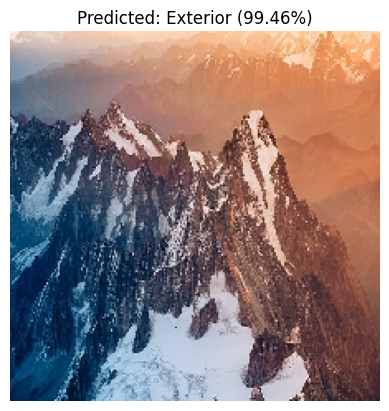

In [46]:
pred_show_image_web(model, url = "https://www.mountainwilderness.fr/media/images/videos/mobile/_768x375_crop_center-center_none/Mountain_Wild%C2%A9MathisDumas-768_2024-05-31-092042_udgi.jpg", true_label="Exterior")

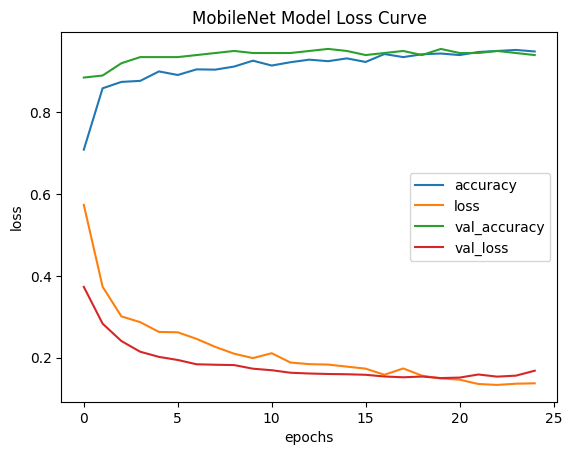

In [50]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("MobileNet Model Loss Curve")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted label: Exterior, True label: Exterior
Confidence: 95.77%


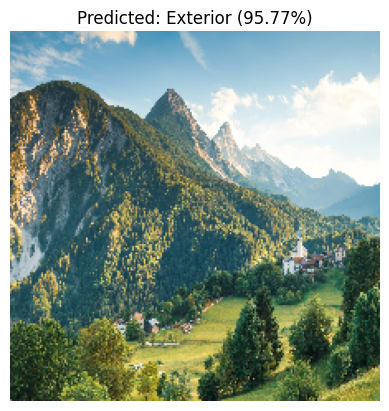

In [51]:

pred_show_image_web(model, url = "https://hips.hearstapps.com/hmg-prod/images/alpe-di-siusi-sunrise-with-sassolungo-or-langkofel-royalty-free-image-1623254127.jpg", true_label="Exterior")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted label: Interior, True label: Interior
Confidence: 79.83%


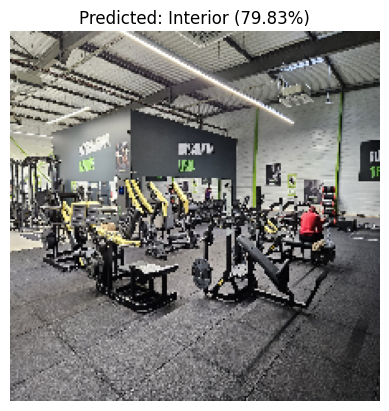

In [53]:

pred_show_image_web(model, url = "https://libertygym.fr/app/uploads/2024/02/PHOTO-2024-04-08-09-37-30-5.jpg", true_label="Interior")